<h1>
<center>Adaboost Regression & Sector Rotation</center>
</h1>

# Packages and Data

In [1]:
import pandas as pd
import numpy as np
import yfinance as yahooFinance
from yahoofinancials import YahooFinancials
from fredapi import Fred
import datetime as datetime
import matplotlib.pyplot as plt

We first import the close prices of ETFs for each sector.

In [2]:
def import_fin(ticker):
    data = pd.DataFrame(YahooFinancials(ticker).get_historical_price_data(start_date='1901-01-01',
                                                                    end_date='2022-06-30',
                                                                    time_interval='daily')[ticker]['prices']).drop('date', axis=1).set_index('formatted_date')
    price = data['close']
    price.index = pd.to_datetime(price.index)
    
    return price

vnq = import_fin("VNQ")
xlk = import_fin("XLK")
xlf = import_fin("XLF")
xlv = import_fin("XLV")
xle = import_fin("XLE")
xly = import_fin("XLY")
xli = import_fin("XLI")
xlc = import_fin("XLC")
xlp = import_fin("XLP")
xlu = import_fin("XLU")
xlb = import_fin("XLB")

We will use the prices over the last 10 days to perform the prediction. Therefore, we need to have a script that transform it into this tructure. The following script will generate an input matrix (prices over the last 10 days) and an output vector (the target price for the prediction).

In [3]:
def ts_split(ts, feature_steps=10, target_steps=1):
    n_obs = len(ts) - feature_steps - target_steps + 1
    X = np.array([ts[idx:idx + feature_steps] for idx in range(n_obs)])
    y = np.array([ts[idx + feature_steps:idx + feature_steps + target_steps]
                  for idx in range(n_obs)])
    return X, y

In [4]:
X_vnq, y_vnq = ts_split(vnq)
X_xlk, y_xlk = ts_split(xlk)
X_xlf, y_xlf = ts_split(xlf)
X_xlv, y_xlv = ts_split(xlv)
X_xle, y_xle = ts_split(xle)
X_xly, y_xly = ts_split(xly)
X_xli, y_xli = ts_split(xli)
X_xlc, y_xlc = ts_split(xlc)
X_xlp, y_xlp = ts_split(xlp)
X_xlu, y_xlu = ts_split(xlu)
X_xlb, y_xlb = ts_split(xlb)

Now, we also want to split it into train and test sets for each ETF.

In [5]:
n = round(len(xlk)/2)
X_vnq_train, y_vnq_train = X_vnq[:round(len(vnq)/2)], y_vnq[:round(len(vnq)/2)]
X_xlk_train, y_xlk_train = X_xlk[:n], y_xlk[:n]
X_xlf_train, y_xlf_train = X_xlf[:n], y_xlf[:n]
X_xlv_train, y_xlv_train = X_xlv[:n], y_xlv[:n]
X_xle_train, y_xle_train = X_xle[:n], y_xle[:n]
X_xly_train, y_xly_train = X_xly[:n], y_xly[:n]
X_xli_train, y_xli_train = X_xli[:n], y_xli[:n]
X_xlc_train, y_xlc_train = X_xlc[:round(len(xlc)/2)], y_xlc[:round(len(xlc)/2)]
X_xlp_train, y_xlp_train = X_xlp[:n], y_xlp[:n]
X_xlu_train, y_xlu_train = X_xlu[:n], y_xlu[:n]
X_xlb_train, y_xlb_train = X_xlb[:n], y_xlb[:n]

X_vnq_test, y_vnq_test = X_vnq[round(len(vnq)/2):], y_vnq[round(len(vnq)/2):]
X_xlk_test, y_xlk_test = X_xlk[n:], y_xlk[n:]
X_xlf_test, y_xlf_test = X_xlf[n:], y_xlf[n:]
X_xlv_test, y_xlv_test = X_xlv[n:], y_xlv[n:]
X_xle_test, y_xle_test = X_xle[n:], y_xle[n:]
X_xly_test, y_xly_test = X_xly[n:], y_xly[n:]
X_xli_test, y_xli_test = X_xli[n:], y_xli[n:]
X_xlc_test, y_xlc_test = X_xlc[round(len(xlc)/2):], y_xlc[round(len(xlc)/2):]
X_xlp_test, y_xlp_test = X_xlp[n:], y_xlp[n:]
X_xlu_test, y_xlu_test = X_xlu[n:], y_xlu[n:]
X_xlb_test, y_xlb_test = X_xlb[n:], y_xlb[n:]

## Predicting Prices Using Adaboost Regressor

The following script will perform the prediction given the optimal hyperparameter.

In [6]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
import matplotlib as mpl
import matplotlib.pyplot as plt

def compute_ada(X, X_train, y_train, y_test, md, n_est, lr, date, ticker):
    base = DecisionTreeRegressor(random_state=0, max_depth = md)
    model = AdaBoostRegressor(n_estimators=n_est, base_estimator=base, learning_rate=lr, loss='exponential', random_state=0)
    model.fit(X_train, y_train)
    y_pred = pd.DataFrame(model.predict(X)).squeeze()
    y_pred.index = pd.to_datetime(date[-len(y_pred):])
    y_test = pd.DataFrame(y_test)
    y_test.index = date[-len(y_test):]
    y_pred_plot = y_pred[y_test.index]
    
    plt.plot(y_pred_plot, label="Prediction")
    plt.plot(y_test, label="Actual")
    plt.title(ticker)
    plt.legend()
    plt.show()
      
    return y_pred

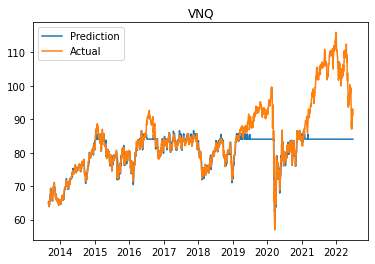

In [7]:
vnq_pred = compute_ada(X_vnq, X_vnq_train, y_vnq_train.ravel(), y_vnq_test.ravel(), 9, 15, 100**(-100), vnq.index, "VNQ")

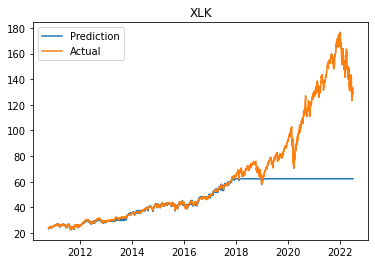

In [8]:
xlk_pred = compute_ada(X_xlk, X_xlk_train, y_xlk_train.ravel(), y_xlk_test.ravel(), 29, 60, 10**-10, xlk.index, "XLK")

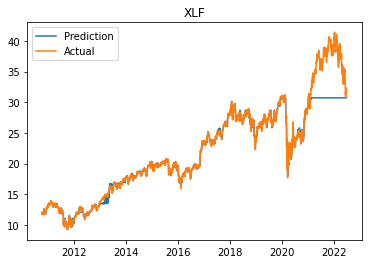

In [9]:
xlf_pred = compute_ada(X_xlf, X_xlf_train, y_xlf_train.ravel(), y_xlf_test.ravel(), 7, 85, 10**-10, xlf.index, "XLF")

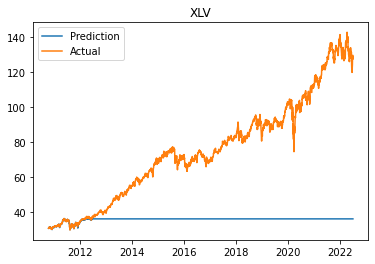

In [10]:
xlv_pred = compute_ada(X_xlv, X_xlv_train, y_xlv_train.ravel(), y_xlv_test.ravel(), 20, 30, 10**(-6), xlv.index, "XLV")

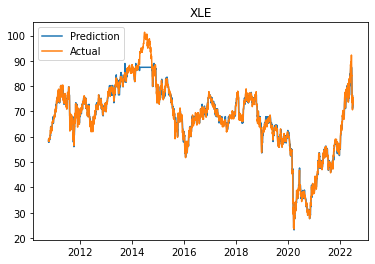

In [11]:
xle_pred = compute_ada(X_xle, X_xle_train, y_xle_train.ravel(), y_xle_test.ravel(), 7, 5, 0.4, xle.index, "XLE")

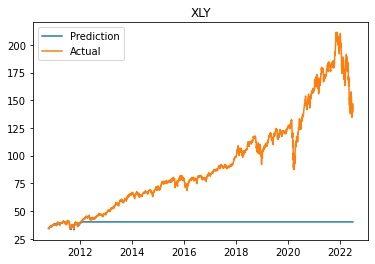

In [12]:
xly_pred = compute_ada(X_xly, X_xly_train, y_xly_train.ravel(), y_xly_test.ravel(), 31, 21, 0.2, xly.index, "XLY")

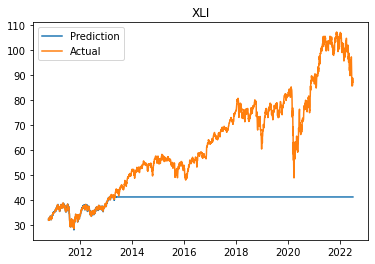

In [13]:
xli_pred = compute_ada(X_xli, X_xli_train, y_xli_train.ravel(), y_xli_test.ravel(), 9, 11, 1, xli.index, "XLI")

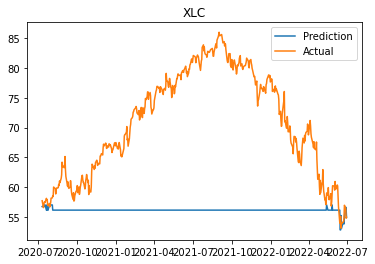

In [14]:
xlc_pred = compute_ada(X_xlc, X_xlc_train, y_xlc_train.ravel(), y_xlc_test.ravel(), 17, 21, 10**-10, xlc.index, "XLC")

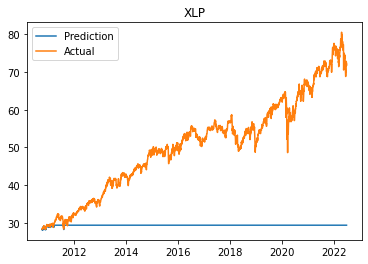

In [15]:
xlp_pred = compute_ada(X_xlp, X_xlp_train, y_xlp_train.ravel(), y_xlp_test.ravel(), 21, 4, 1.2, xlp.index, "XLP")

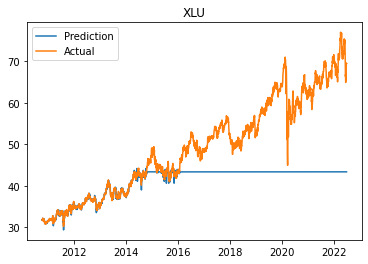

In [16]:
xlu_pred = compute_ada(X_xlu, X_xlu_train, y_xlu_train.ravel(), y_xlu_test.ravel(), 9, 9, 2, xlu.index, "XLU")

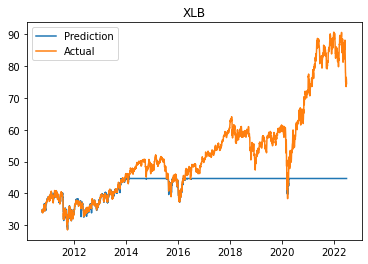

In [17]:
xlb_pred = compute_ada(X_xlb, X_xlb_train, y_xlb_train.ravel(), y_xlb_test.ravel(), 23, 15, 10**-10, xlb.index, "XLB")

Overall, even after spending a lot of time tuning the hyperparameters, the result is not quite sucessful as expected.

# Sector Rotation

Throughout this process, we will consider and adjust the portfolio monthly. Thata is, we will ignore the changes in the middle of the month and consider the information of the prices at the end of the month. The following code will be used to extract the last trading day of each month.

In [18]:
def extract(months):
  ind = []
  for i in range(1,len(months)):
    if months[i-1] != months[i]:
      ind.append(i-1)
  ind = np.array(ind)
  return ind

In [19]:
ETF_list = [vnq,xlk,xlf,xlv,xle,xly,xli,xlc,xlp,xlu,xlb]
ETF = []
for i in range(len(ETF_list)):
    ETF.append(ETF_list[i][extract(ETF_list[i].index.month)])

The following table shows the price of each ETF at the end of each month. Note that NaN's might exist because the late inception date.

In [20]:
name_list = ["vnq", "xlk","xlf", "xlv", "xle", "xly", "xli", "xlc", "xlp", "xlu", "xlb"]
table1 = pd.DataFrame(ETF).T
table1.columns = [k.upper() for k in name_list]
table1

,VNQ,XLK,XLF,XLV,XLE,XLY,XLI,XLC,XLP,XLU,XLB
formatted_date,,,,,,,,,,,
1998-12-31,NaN,32.625000,19.039398,26.000000,23.343750,26.125000,24.562500,NaN,27.156250,30.234375,21.921875
1999-01-29,NaN,37.812500,19.369415,27.250000,21.812500,27.468750,24.296875,NaN,26.796875,29.484375,21.109375
1999-02-26,NaN,34.062500,19.674046,27.281250,21.625000,27.296875,24.515625,NaN,26.515625,28.671875,21.437500
1999-03-31,NaN,36.593750,20.257919,28.000000,24.593750,28.593750,24.937500,NaN,26.437500,26.687500,21.750000
1999-04-30,NaN,36.812500,21.679529,29.000000,28.234375,29.343750,28.687500,NaN,25.515625,29.265625,27.125000
...,...,...,...,...,...,...,...,...,...,...,...
2022-01-31,106.239998,161.970001,39.060001,131.229996,65.919998,184.949997,100.739998,73.949997,75.970001,69.250000,84.449997
2022-02-28,102.540001,154.070007,38.520000,129.960007,70.580002,177.429993,99.889999,68.449997,74.900002,67.930000,83.379997
2022-03-31,108.370003,158.929993,38.320000,136.990005,76.440002,185.000000,102.980003,68.779999,75.889999,74.459999,88.150002


In [21]:
returns = pd.DataFrame.diff(table1)/table1.shift()
returns

,VNQ,XLK,XLF,XLV,XLE,XLY,XLI,XLC,XLP,XLU,XLB
formatted_date,,,,,,,,,,,
1998-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-01-29,NaN,0.159004,0.017333,0.048077,-0.065596,0.051435,-0.010814,NaN,-0.013234,-0.024806,-0.037063
1999-02-26,NaN,-0.099174,0.015727,0.001147,-0.008596,-0.006257,0.009003,NaN,-0.010496,-0.027557,0.015544
1999-03-31,NaN,0.074312,0.029677,0.026346,0.137283,0.047510,0.017208,NaN,-0.002946,-0.069210,0.014577
1999-04-30,NaN,0.005978,0.070176,0.035714,0.148030,0.026230,0.150376,NaN,-0.034870,0.096604,0.247126
...,...,...,...,...,...,...,...,...,...,...,...
2022-01-31,-0.084217,-0.068442,0.000256,-0.068564,0.187748,-0.095334,-0.047916,-0.048018,-0.014784,-0.032551,-0.067984
2022-02-28,-0.034827,-0.048774,-0.013825,-0.009678,0.070692,-0.040660,-0.008438,-0.074375,-0.014085,-0.019061,-0.012670
2022-03-31,0.056856,0.031544,-0.005192,0.054094,0.083026,0.042665,0.030934,0.004821,0.013218,0.096128,0.057208


Now, we will consider the predicted prices and returns.

In [22]:
date = xlc_pred.index

Pred_list = [vnq_pred.squeeze(), xlk_pred.squeeze(),xlf_pred.squeeze(),xlv_pred.squeeze(),xle_pred.squeeze(),
             xly_pred.squeeze(),xli_pred.squeeze(),xlc_pred.squeeze(),xlp_pred.squeeze(),xlu_pred.squeeze(),
             xlb_pred.squeeze()]
predict = []
for i in range(len(Pred_list)):
    predict.append(Pred_list[i][extract(Pred_list[i].index.month)])

The following table shows the predicted price at the end of each month.

In [23]:
table2 = pd.DataFrame(predict).T
table2.columns = [k.upper() for k in name_list]
table2

,VNQ,XLK,XLF,XLV,XLE,XLY,XLI,XLC,XLP,XLU,XLB
formatted_date,,,,,,,,,,,
1999-01-29,NaN,37.81250,18.890384,27.250000,21.810238,27.468750,24.260662,NaN,26.796875,29.685710,21.109375
1999-02-26,NaN,34.06250,19.311831,27.281250,21.810238,27.296875,24.479772,NaN,26.515625,28.800256,21.437500
1999-03-31,NaN,36.59375,20.409207,28.000000,24.869714,28.593750,25.226346,NaN,26.437500,26.824205,21.750000
1999-04-30,NaN,36.81250,21.972057,29.000000,28.510705,29.343750,28.930833,NaN,25.515625,29.611821,27.125000
1999-05-28,NaN,36.93750,20.145103,28.109375,27.355592,28.015625,27.896918,NaN,25.250000,29.611821,24.656250
...,...,...,...,...,...,...,...,...,...,...,...
2022-01-31,84.050003,62.25000,30.720669,36.270000,65.480357,40.169998,41.139999,56.119999,29.379999,43.360001,44.680000
2022-02-28,84.050003,62.25000,30.720669,36.270000,68.321333,40.169998,41.139999,56.119999,29.379999,43.360001,44.680000
2022-03-31,84.050003,62.25000,30.720669,36.270000,76.563611,40.169998,41.139999,56.119999,29.379999,43.360001,44.680000


We will rank the first 4 highest returns at each time point. As shown below, 1 means we select the ETF and 0 otherwise.

In [24]:
ind = []
for i in range(len(table2)):
    ret = (table2.iloc[i]-table1.iloc[i])/table1.iloc[i]
    ind.append(((-ret).rank()<5)*1)

ind = pd.DataFrame(ind)
ind.index = table2.index
ind    

,VNQ,XLK,XLF,XLV,XLE,XLY,XLI,XLC,XLP,XLU,XLB
formatted_date,,,,,,,,,,,
1999-01-29,0,1,1,1,0,1,0,0,0,0,0
1999-02-26,0,0,0,1,1,0,1,0,0,0,1
1999-03-31,0,1,1,0,1,1,0,0,0,0,0
1999-04-30,0,0,0,0,1,0,1,0,0,1,1
1999-05-28,0,1,0,0,0,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...
2022-01-31,1,0,1,0,1,0,0,1,0,0,0
2022-02-28,1,0,1,0,1,0,0,1,0,0,0
2022-03-31,1,0,1,0,1,0,0,1,0,0,0


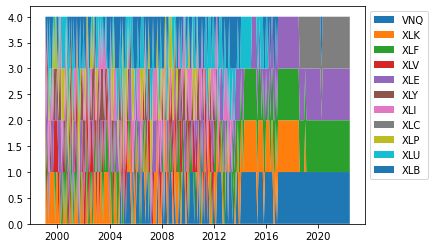

In [25]:
plt.stackplot(ind.index, ind.T.iloc[0], ind.T.iloc[1], ind.T.iloc[2],ind.T.iloc[3],ind.T.iloc[4],ind.T.iloc[5],ind.T.iloc[6],
             ind.T.iloc[7],ind.T.iloc[8],ind.T.iloc[9],ind.T.iloc[10], labels = ind.T.index)
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.show()

## Equally weighted portfolio

In [26]:
port1 = np.zeros(len(returns)-1)
port1[0] = 100
bnch = np.zeros(len(returns)-1)
bnch[0] = 100

for i in range(1,len(returns)-1):
    port1[i] = port1[i-1]*np.sum(0.25*(1+returns.iloc[i+1])*ind.iloc[i])
    #print(np.sum((1+returns.iloc[i+1])*ind.iloc[i])/4)
    bnch[i] = np.mean(bnch[i-1]*(1+returns.iloc[i+1]))

port1 = pd.DataFrame(port1).squeeze()
port1.index = ind.index
bnch = pd.DataFrame(bnch).squeeze()
bnch.index = ind.index

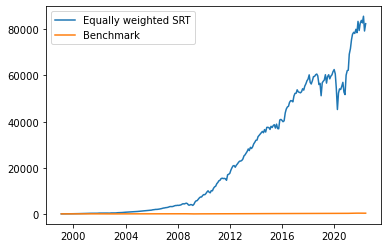

In [27]:
plt.plot(port1)
plt.plot(bnch)
plt.legend(["Equally weighted SRT","Benchmark"])
plt.show()

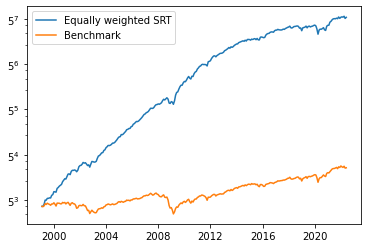

In [28]:
plt.plot(port1)
plt.plot(bnch)
plt.legend(["Equally weighted SRT","Benchmark"])
plt.yscale('log',base=5)
plt.show()

### Performance

In [29]:
ret_port = np.diff(port1)/port1[:-1]
ret_bnch = np.diff(bnch)/bnch[:-1]

In [30]:
print(np.mean(ret_port), np.mean(ret_bnch))

0.02537040011040194 0.00585096510804225


The average return is 2.54% compared to the benchmark of 0.59%.

In [31]:
print(np.std(ret_port), np.std(ret_bnch))

0.0474955128629344 0.043118850614371505


The standard deviation is 0.047 compared to 0.043 benchmark.

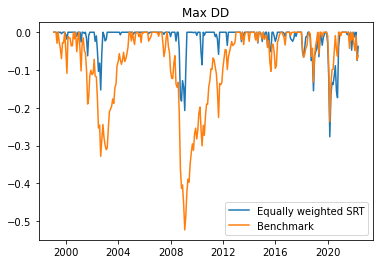

In [32]:
def DD(ret):
  dd = np.zeros(len(ret))
  dd[0] = 0
  for i in range(1,len(ret)):
    dd[i] = min(0,(1+dd[i-1])*(1+ret[i])-1)

  dd = pd.DataFrame(dd).squeeze()
  dd.index = ret.index
  return dd

plt.plot(DD(np.diff(port1)/port1[:-1]), label='Equally weighted SRT')
plt.plot(DD(np.diff(bnch)/bnch[:-1]), label='Benchmark')
plt.legend()
plt.title("Max DD")
plt.show()

In [33]:
print(np.min(DD(np.diff(port1)/port1[:-1])), np.min(DD(np.diff(bnch)/bnch[:-1])))

-0.27650585688444196 -0.5229911488243362


The maximum drawdown is also low, 27.65% compared to benckmark of 52.23%.

For Sharpe ratio, we need to get a risk free rate. I decided to use 3-month treasury bill, which can be found in FRED website.

In [34]:
fred = Fred(api_key='fec003d5c966f4c13258c8476a6b4dba')
tbill3mo = fred.get_series('DGS3MO').dropna()/100/12
tbill3mo

1981-09-01    0.014175
1981-09-02    0.013875
1981-09-03    0.014133
1981-09-04    0.013867
1981-09-08    0.013783
                ...   
2022-08-11    0.002183
2022-08-12    0.002192
2022-08-15    0.002267
2022-08-16    0.002250
2022-08-17    0.002233
Length: 10241, dtype: float64

In [35]:
rf = tbill3mo[port1.index].iloc[:-1]

In [36]:
sharpe_port = np.mean(ret_port-rf) / np.std(ret_port-rf)
sharpe_bnch = np.mean(ret_bnch-rf) / np.std(ret_bnch-rf)
print(sharpe_port,sharpe_bnch)

0.5064958987335916 0.10338546559103308


The sharpe ratio of the portfolio is 0.51, which way outperforms the benchmark of 0.1.

We can also compute information ratio.

In [37]:
info = np.mean(ret_port-ret_bnch)/np.std(ret_port-ret_bnch)
info

0.9529121696825098

The last we want to consider is Calmar ratio.

In [38]:
cal_port = -np.mean(ret_port-rf)/np.min(DD(ret_port))
cal_bnch = -np.mean(ret_bnch-rf)/np.min(DD(ret_bnch))
print(cal_port,cal_bnch)

0.08676476461263101 0.008549916369109798


The Clamar ratios of the portfolio and the benchmark are 0.08 and 0.008, respectively.

## Mean-Variance portfolio

For mean-variance portfolio, we basically will adjust the weights of selected 4 ETF's at each time point. The weight will be given by solving the Markowitz model. I will use the 90-day means and covariances to solve this model.

The following are the returns of each ETF.

In [39]:
table = pd.DataFrame(ETF_list).T
table.columns = [k.upper() for k in name_list]

returns_all = pd.DataFrame.diff(table)/table.shift()
returns_all

,VNQ,XLK,XLF,XLV,XLE,XLY,XLI,XLC,XLP,XLU,XLB
formatted_date,,,,,,,,,,,
1998-12-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-12-23,NaN,0.023891,0.014745,0.022472,0.020819,0.004294,0.017450,NaN,0.024175,-0.004191,0.010503
1998-12-24,NaN,-0.003810,0.006605,0.006105,-0.005263,0.018326,0.013193,NaN,-0.001727,0.018411,0.023014
1998-12-28,NaN,0.002868,-0.013123,-0.014563,-0.005291,-0.008998,0.005208,NaN,-0.005767,-0.005165,-0.008708
1998-12-29,NaN,0.002860,0.010638,0.022167,0.009973,0.021792,0.014249,NaN,0.022042,0.016615,0.018302
...,...,...,...,...,...,...,...,...,...,...,...
2022-06-23,0.012549,0.014970,-0.003833,0.022446,-0.037067,0.015710,-0.005101,0.012366,0.019404,0.023540,-0.013680
2022-06-24,0.021277,0.035942,0.036871,0.016602,0.013162,0.038138,0.034957,0.038104,0.019594,0.017396,0.039706
2022-06-27,-0.001503,-0.006744,-0.003401,0.003715,0.029334,-0.010477,-0.002364,-0.009484,-0.002745,0.008115,-0.008240


The following tables shows the means and covariances of the past 90 days price for each ETF.

In [40]:
Mean = returns_all.rolling(90).mean()
start_date = Mean.index[90:]
Mean = Mean.loc[start_date]
Mean = Mean.iloc[extract(xlk['1999-05-04':].index.month)]
Mean

,VNQ,XLK,XLF,XLV,XLE,XLY,XLI,XLC,XLP,XLU,XLB
formatted_date,,,,,,,,,,,
1999-05-28,NaN,0.000409,0.000770,0.000235,0.002412,0.000682,0.001724,NaN,-0.000196,-0.000200,0.001586
1999-06-30,NaN,0.001622,0.000849,0.000662,0.002874,0.000835,0.002005,NaN,-0.000484,0.000391,0.002138
1999-07-30,NaN,0.001833,0.000015,0.000445,0.001829,-0.000039,0.001788,NaN,-0.000861,0.001334,0.001934
1999-08-31,NaN,0.001094,-0.001488,-0.001180,0.000953,-0.001422,0.000243,NaN,-0.000598,0.000023,-0.000375
1999-09-30,NaN,0.001416,-0.001304,-0.000610,0.000050,-0.000772,0.000104,NaN,-0.001092,0.000013,-0.001034
...,...,...,...,...,...,...,...,...,...,...,...
2022-01-31,-0.000005,0.000626,0.000643,0.000006,0.003484,0.000258,0.000229,-0.000938,0.000885,0.000651,0.000645
2022-02-28,-0.000376,-0.000210,-0.000315,0.000140,0.002323,-0.000672,-0.000345,-0.001863,0.000720,0.000388,-0.000088
2022-03-31,-0.000029,-0.000661,-0.000085,0.000381,0.003897,-0.001304,-0.000223,-0.001503,0.000623,0.001176,0.000064


In [41]:
import numpy.ma as ma
Cov = returns_all.rolling(90).cov()
start_date = Cov.index[90*11:]
Cov = Cov.loc[start_date]
dummy = extract(xlk['1999-05-04':].index.month)*11
Cov = Cov.iloc[np.array([k+i for k in dummy for i in range(11)])]
Cov

VNQ       XLK       XLF       XLV       XLE  \
formatted_date                                                         
1999-05-28     VNQ       NaN       NaN       NaN       NaN       NaN   
               XLK       NaN  0.000443  0.000191  0.000186  0.000042   
               XLF       NaN  0.000191  0.000260  0.000154  0.000088   
               XLV       NaN  0.000186  0.000154  0.000186  0.000025   
               XLE       NaN  0.000042  0.000088  0.000025  0.000296   
...                      ...       ...       ...       ...       ...   
2022-05-31     XLI  0.000151  0.000249  0.000179  0.000130  0.000092   
               XLC  0.000189  0.000398  0.000228  0.000157  0.000093   
               XLP  0.000122  0.000147  0.000121  0.000116  0.000049   
               XLU  0.000110  0.000091  0.000069  0.000089  0.000084   
               XLB  0.000167  0.000266  0.000210  0.000152  0.000124   

                         XLY       XLI       XLC       XLP       XLU       XLB  
formatted_date                                                                  
1999-05-28     VNQ       NaN       NaN       NaN       NaN       NaN       NaN  
               XLK  0.000195  0.000063       NaN  0.000171  0.000084 -0.000005  
               XLF  0.000171  0.000079       NaN  0.000130  0.000099  0.000046  
               XLV  0.000144  0.000063       NaN  0.000133  0.000073  0.000024  
               XLE  0.000056  0.000076       NaN  0.000020  0.000066  0.000126  
...                      ...       ...       ...       ...       ...       ...  
2022-05-31     XLI  0.000269  0.000173  0.000207  0.000110  0.000074  0.000181  
               XLC  0.000422  0.000207  0.000429  0.000102  0.000070  0.000229  
               XLP  0.000150  0.000110  0.000102  0.000161  0.000087  0.000119  
               XLU  0.000075  0.000074  0.000070  0.000087  0.000125  0.000081  
               XLB  0.000277  0.000181  0.000229  0.000119  0.000081  0.000235  

[3047 rows x 11 columns]

Now that we have all the inputs needed to solve the model, we will use the ```cvxopt``` package to solve the quadratic optimization problem.

In [42]:
import cvxopt as opt
from cvxopt import blas, solvers
def optimal_portfolio(ret, cov):
    n = len(ret)
    returns = ret
    
    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
    # Convert to cvxopt matrices
    #S = opt.matrix(np.cov(returns))
    S = opt.matrix(cov)
    pbar = opt.matrix(returns)
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    solvers.options['show_progress'] = False
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks


In [43]:
returns2 = returns["1999-05-28":]
returns2

,VNQ,XLK,XLF,XLV,XLE,XLY,XLI,XLC,XLP,XLU,XLB
formatted_date,,,,,,,,,,,
1999-05-28,NaN,0.003396,-0.060304,-0.030711,-0.021583,-0.045261,-0.019608,NaN,-0.010410,0.011746,-0.091014
1999-06-30,NaN,0.096024,0.040498,0.043913,0.015271,0.063023,0.060000,NaN,0.013614,0.034828,0.054499
1999-07-30,NaN,-0.011579,-0.061078,-0.029819,0.018942,-0.074502,-0.036688,NaN,-0.037241,0.003060,-0.011418
1999-08-31,NaN,0.035143,-0.044005,-0.045005,0.010935,-0.038549,0.008161,NaN,0.017121,-0.047789,-0.044985
1999-09-30,NaN,-0.004149,-0.055370,-0.013793,-0.050297,-0.015920,-0.007016,NaN,-0.092269,0.017619,-0.034373
...,...,...,...,...,...,...,...,...,...,...,...
2022-01-31,-0.084217,-0.068442,0.000256,-0.068564,0.187748,-0.095334,-0.047916,-0.048018,-0.014784,-0.032551,-0.067984
2022-02-28,-0.034827,-0.048774,-0.013825,-0.009678,0.070692,-0.040660,-0.008438,-0.074375,-0.014085,-0.019061,-0.012670
2022-03-31,0.056856,0.031544,-0.005192,0.054094,0.083026,0.042665,0.030934,0.004821,0.013218,0.096128,0.057208


In [44]:
ind2 = ind["1999-05-28":]
ind2.iloc[65].iloc[0] = 0
ind2.iloc[65].iloc[6] = 1
ind2.iloc[230].iloc[7] = 0
ind2.iloc[230].iloc[1] = 1
ind2.iloc[231].iloc[7] = 0
ind2.iloc[231].iloc[1] = 1
ind2.iloc[232].iloc[7] = 0
ind2.iloc[232].iloc[1] = 1
ind2

,VNQ,XLK,XLF,XLV,XLE,XLY,XLI,XLC,XLP,XLU,XLB
formatted_date,,,,,,,,,,,
1999-05-28,0,1,0,0,0,0,1,0,1,1,0
1999-06-30,0,1,0,0,0,1,1,0,0,0,1
1999-07-30,0,1,0,0,1,0,0,0,0,1,1
1999-08-31,0,1,0,0,1,0,1,0,1,0,0
1999-09-30,0,1,0,1,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
2022-01-31,1,0,1,0,1,0,0,1,0,0,0
2022-02-28,1,0,1,0,1,0,0,1,0,0,0
2022-03-31,1,0,1,0,1,0,0,1,0,0,0


In [45]:
port1 = np.zeros(253)#np.zeros(len(Mean))
port1[0] = 100
bnch = np.zeros(253)
bnch[0] = 100

for i in range(1,253):
    c = Cov.iloc[i*11:i*11+11]
    m = Mean.iloc[i]
    ind3 = ind2.iloc[i]
    #print(i,m.iloc[np.where(ind3==True)[0]],np.array(c.iloc[np.where(ind3==True)[0]][ind3.index[np.where(ind3==True)[0]]]))
    weights, ret, risks = optimal_portfolio(m.iloc[np.where(ind3==True)[0]],np.array(c.iloc[np.where(ind3==True)[0]][ind3.index[np.where(ind3==True)[0]]]))
    w = pd.DataFrame(weights).squeeze()
    w.index = (m.iloc[np.where(ind3==True)[0]]).index
    m2 = 1+returns2.iloc[i+1].iloc[np.where(ind3==True)[0]]
    #print(m2,w,np.sum(w*m2))
    #print(i,np.sum(w*m2))
    port1[i] = port1[i-1]*(np.sum(w*m2))
    bnch[i] = np.mean(bnch[i-1]*(1+returns2.iloc[i+1]))

port1 = pd.DataFrame(port1).squeeze()
port1.index = Mean.index[:253]
bnch = pd.DataFrame(bnch).squeeze()
bnch.index = Mean.index[:253]

     pcost       dcost       gap    pres   dres
 0: -1.6458e-03 -1.0021e+00  1e+00  2e-16  3e+00
 1: -1.6463e-03 -1.2134e-02  1e-02  6e-17  3e-02
 2: -1.6906e-03 -2.2335e-03  5e-04  8e-17  1e-03
 3: -2.1079e-03 -2.2382e-03  1e-04  2e-16  9e-05
 4: -2.1220e-03 -2.1270e-03  5e-06  1e-16  3e-06
 5: -2.1258e-03 -2.1258e-03  5e-08  3e-16  3e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.6452e-03 -1.0021e+00  1e+00  0e+00  3e+00
 1: -1.6457e-03 -1.2134e-02  1e-02  9e-17  3e-02
 2: -1.6899e-03 -2.2330e-03  5e-04  7e-17  1e-03
 3: -2.1073e-03 -2.2364e-03  1e-04  1e-16  9e-05
 4: -2.1205e-03 -2.1254e-03  5e-06  1e-16  3e-06
 5: -2.1243e-03 -2.1243e-03  5e-08  2e-16  3e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.6444e-03 -1.0021e+00  1e+00  2e-16  3e+00
 1: -1.6450e-03 -1.2133e-02  1e-02  2e-16  3e-02
 2: -1.6892e-03 -2.2323e-03  5e-04  8e-17  1e-03
 3: -2.1057e-03 -2.2342e-03  1e-04  7e-16  8e-05
 4: -2.1187e-03 -2.1237e

In [46]:
np.mean(np.diff(port1)/port1[:-1])

0.003425284368153362

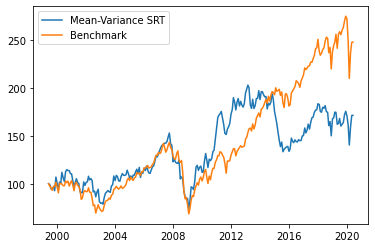

In [47]:
plt.plot(port1)
plt.plot(bnch)
plt.legend(["Mean-Variance SRT","Benchmark"])
plt.show()

### Performance

In [48]:
ret_port = np.diff(port1)/port1[:-1]
ret_bnch = np.diff(bnch)/bnch[:-1]

In [49]:
print(np.mean(ret_port), np.mean(ret_bnch))

0.003425284368153362 0.004561304686898108


The average return is 0.34% compared to the benchmark of 0.45%.

In [50]:
print(np.std(ret_port), np.std(ret_bnch))

0.05065941680294413 0.04309445210215032


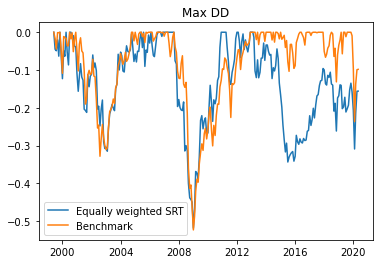

In [51]:
def DD(ret):
  dd = np.zeros(len(ret))
  dd[0] = 0
  for i in range(1,len(ret)):
    dd[i] = min(0,(1+dd[i-1])*(1+ret[i])-1)

  dd = pd.DataFrame(dd).squeeze()
  dd.index = ret.index
  return dd

plt.plot(DD(np.diff(port1)/port1[:-1]), label='Equally weighted SRT')
plt.plot(DD(np.diff(bnch)/bnch[:-1]), label='Benchmark')
plt.legend()
plt.title("Max DD")
plt.show()

In [52]:
print(np.min(DD(np.diff(port1)/port1[:-1])), np.min(DD(np.diff(bnch)/bnch[:-1])))

-0.5183040966570416 -0.522991148824336


The maximum drawdown is also low, 51.83% compared to benckmark of 52.29%.

Sharpe ratio

In [53]:
sharpe_port = np.mean(ret_port-rf) / np.std(ret_port-rf)
sharpe_bnch = np.mean(ret_bnch-rf) / np.std(ret_bnch-rf)
print(sharpe_port,sharpe_bnch)

0.03871142594455215 0.07171165872024007


The sharpe ratio of the portfolio is 0.04, which way outperforms the benchmark of 0.07.

We can also compute information ratio.

In [54]:
info = np.mean(ret_port-ret_bnch)/np.std(ret_port-ret_bnch)
info

-0.032268629359165704

The last we want to consider is Calmar ratio.

In [55]:
cal_port = -np.mean(ret_port-rf)/np.min(DD(ret_port))
cal_bnch = -np.mean(ret_bnch-rf)/np.min(DD(ret_bnch))
print(cal_port,cal_bnch)

0.0037885309037589752 0.005926737791724926


The Clamar ratios of the portfolio and the benchmark are 0.04 and 0.006, respectively.